In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys

In [2]:
conn = sqlite3.connect('/run/media/leyan/8854FE2154FE11A4/ECE143dataset/wildfile/FPA_FOD_20170508.sqlite')

In [3]:
data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)

In [5]:
data_dates_arr = date['DISCOVERY_DATE']
fire_year_arr = data_dates['FIRE_YEAR']
fire_size_arr = data_size['FIRE_SIZE']

In [9]:
data_size.groupby('FIRE_SIZE_CLASS').count()

,FIRE_SIZE
FIRE_SIZE_CLASS,
A,666919
B,939376
C,220077
D,28427
E,14107
F,7786
G,3773


In [8]:
data_size.groupby('FIRE_SIZE_CLASS').mean()

,FIRE_SIZE
FIRE_SIZE_CLASS,
A,0.118801
B,2.146998
C,28.531914
D,161.801034
E,512.854904
F,2130.395128
G,27388.190703


In [16]:
size_class = []
for c in data_size['FIRE_SIZE_CLASS']:
    d = {"A":1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    size_class.append(d[c])

In [17]:
df = data_location
df['date'] = data_dates_arr
df['fire_class'] = size_class

In [18]:
df.describe

<bound method NDFrame.describe of           LATITUDE   LONGITUDE STATE                 date  fire_class
0        40.036944 -121.005833    CA  2005-02-02 00:00:00           1
1        38.933056 -120.404444    CA  2004-05-12 00:00:00           1
2        38.984167 -120.735556    CA  2004-05-31 00:00:00           1
3        38.559167 -119.913333    CA  2004-06-28 00:00:00           1
4        38.559167 -119.933056    CA  2004-06-28 00:00:00           1
...            ...         ...   ...                  ...         ...
1880460  40.481637 -122.389375    CA  2015-09-26 00:00:00           1
1880461  37.617619 -120.938570    CA  2015-10-05 00:00:00           1
1880462  37.617619 -120.938570    CA  2015-05-02 00:00:00           1
1880463  37.672235 -120.898356    CA  2015-10-14 00:00:00           2
1880464  34.263217 -116.830950    CA  2015-03-14 00:00:00           1

[1880465 rows x 5 columns]>

# randomly select 3500 samples, 500 for each class

In [20]:
sample_df = pd.DataFrame()
num_samples = 500
for i in range(1, 8):
    s = df[df['fire_class'] == i].sample(n = num_samples)
    sample_df = pd.concat([sample_df, s])
print(sample_df)

          LATITUDE   LONGITUDE STATE                 date  fire_class
17447    34.150278 -111.161111    AZ  2006-07-08 00:00:00           1
1408617  34.549600  -83.314900    GA  1997-09-05 00:00:00           1
1774717  38.932217 -121.090600    CA  2014-02-26 00:00:00           1
661920   37.474330  -78.271670    VA  2006-03-11 00:00:00           1
69324    34.443333 -118.091667    CA  1994-05-15 00:00:00           1
...            ...         ...   ...                  ...         ...
1564624  45.534167 -116.297500    ID  2012-09-06 00:00:00           7
358740   35.507217  -83.457391    NC  2001-11-10 00:00:00           7
628216   33.513660 -102.827900    TX  2006-03-12 00:00:00           7
330099   43.146400 -113.563900    ID  2007-08-16 00:00:00           7
305615   65.516900 -143.172400    AK  2004-06-14 00:00:00           7

[3500 rows x 5 columns]


# correlate with monthly average wind speed

In [5]:
import os 
import numpy as np
import iris   

import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
from iris.time import PartialDateTime

In [22]:
PATH = "/run/media/leyan/8854FE2154FE11A4/ECE143dataset/adaptor.mars.internal.nc"

In [23]:
raw = iris.load_raw(PATH)
print(raw)

0: 10 metre wind speed / (m s**-1)     (time: 493; expver: 2; latitude: 721; longitude: 1440)
1: surface_air_pressure / (Pa)         (time: 493; expver: 2; latitude: 721; longitude: 1440)


In [24]:
cube = raw[0] # cube0 is 10 metre wind speed
cube = cube.extract(iris.Constraint(expver = 1))

In [25]:
def query_wind(y, m, lat, long, cube):
    """
    Args:
        year: integer indicate year, support 1979 to 2019
        month: integer indicate month, 1 to 12
        latitude: float, -90 to 90, resolution 0.25
        longitude: float, 0 to 360, 5 means East5, 185 means West175, resolution 0.25
        cube: precipation data
    Return:
        the average precipation in that given month (mm/day)
        its type is float  
    """
    if long < 0:
        long += 360
    time_cons = iris.Constraint(time = PartialDateTime(year = y, month = m))
    lat_cons = iris.Constraint(latitude = lambda x : lat-0.125 <= x <lat+0.125)
    long_cons = iris.Constraint(longitude = lambda x : long-0.125 <= x <long+0.125)
#     exp_cons = iris.Constraint(expver = 1)
    wind = cube.extract(lat_cons & long_cons & time_cons)
#     print(rain.data)
    return float(wind.data) # only one answer

In [1]:
%%time
wind_series = []
for index, row in sample_df.iterrows():
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    wind_series.append(query_wind(year, month, lat, long, cube))

In [27]:
sample_df['wind'] = wind_series

In [28]:
sample_df.describe

<bound method NDFrame.describe of           LATITUDE   LONGITUDE STATE                 date  fire_class  \
17447    34.150278 -111.161111    AZ  2006-07-08 00:00:00           1   
1408617  34.549600  -83.314900    GA  1997-09-05 00:00:00           1   
1774717  38.932217 -121.090600    CA  2014-02-26 00:00:00           1   
661920   37.474330  -78.271670    VA  2006-03-11 00:00:00           1   
69324    34.443333 -118.091667    CA  1994-05-15 00:00:00           1   
...            ...         ...   ...                  ...         ...   
1564624  45.534167 -116.297500    ID  2012-09-06 00:00:00           7   
358740   35.507217  -83.457391    NC  2001-11-10 00:00:00           7   
628216   33.513660 -102.827900    TX  2006-03-12 00:00:00           7   
330099   43.146400 -113.563900    ID  2007-08-16 00:00:00           7   
305615   65.516900 -143.172400    AK  2004-06-14 00:00:00           7   

             wind  
17447    1.885379  
1408617  2.074109  
1774717  2.425365  
661920   

In [29]:
sample_df = sample_df.drop(columns=['STATE'])

In [30]:
sample_df

,LATITUDE,LONGITUDE,date,fire_class,wind
17447,34.150278,-111.161111,2006-07-08 00:00:00,1,1.885379
1408617,34.549600,-83.314900,1997-09-05 00:00:00,1,2.074109
1774717,38.932217,-121.090600,2014-02-26 00:00:00,1,2.425365
661920,37.474330,-78.271670,2006-03-11 00:00:00,1,3.078590
69324,34.443333,-118.091667,1994-05-15 00:00:00,1,2.529557
...,...,...,...,...,...
1564624,45.534167,-116.297500,2012-09-06 00:00:00,7,1.462686
358740,35.507217,-83.457391,2001-11-10 00:00:00,7,2.028876
628216,33.513660,-102.827900,2006-03-12 00:00:00,7,5.170843
330099,43.146400,-113.563900,2007-08-16 00:00:00,7,4.055931


In [31]:
sample_df.to_csv('./sample_with_wind.csv')

In [9]:
sample_df = pd.read_csv('./sample_with_wind.csv')
sample_df.describe

<bound method NDFrame.describe of       Unnamed: 0   LATITUDE   LONGITUDE                 date  fire_class  \
0          17447  34.150278 -111.161111  2006-07-08 00:00:00           1   
1        1408617  34.549600  -83.314900  1997-09-05 00:00:00           1   
2        1774717  38.932217 -121.090600  2014-02-26 00:00:00           1   
3         661920  37.474330  -78.271670  2006-03-11 00:00:00           1   
4          69324  34.443333 -118.091667  1994-05-15 00:00:00           1   
...          ...        ...         ...                  ...         ...   
3495     1564624  45.534167 -116.297500  2012-09-06 00:00:00           7   
3496      358740  35.507217  -83.457391  2001-11-10 00:00:00           7   
3497      628216  33.513660 -102.827900  2006-03-12 00:00:00           7   
3498      330099  43.146400 -113.563900  2007-08-16 00:00:00           7   
3499      305615  65.516900 -143.172400  2004-06-14 00:00:00           7   

          wind  
0     1.885379  
1     2.074109  
2 

# correlate with precipitation

In [6]:
PATH = os.path.join(os.getcwd(), "precip.mon.mean.nc")
rain_cube = iris.load_cube(PATH)
print(rain_cube.shape)

(492, 72, 144)


In [7]:
def query_rain(y, m, lat, long, cube):
    """
    Args:
        year: integer indicate year, support 1979 to 2019
        month: integer indicate month, 1 to 12
        latitude: float, -90 to 90
        longitude: float, 0 to 360, 5 means East5, 185 means West175
        cube: precipation data
    Return:
        the average precipation in that given month (mm/day)
        its type is float  
    """
    if long < 0:
        long += 360
    time_cons = iris.Constraint(time = PartialDateTime(year = y, month = m))
    lat_cons = iris.Constraint(latitude = lambda x : lat-1.25 <= x <lat+1.25)
    long_cons = iris.Constraint(longitude = lambda x : long-1.25 <= x <long+1.25)
    rain = cube.extract(lat_cons & long_cons & time_cons)
#     print(rain.data)
    return float(rain.data) # only one answer

In [2]:
%%time
rain_series = []
for index, row in sample_df.iterrows():
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    rain_series.append(query_rain(year, month, lat, long, rain_cube))

In [12]:
sample_df['rain'] = rain_series

In [14]:
sample_df.to_csv('./sample_with_rain.csv')

In [17]:
sample_df_show = sample_df.drop(columns=['date', 'Unnamed: 0'])

In [18]:
sample_df_show

,LATITUDE,LONGITUDE,fire_class,wind,rain
0,34.150278,-111.161111,1,1.885379,1.62
1,34.549600,-83.314900,1,2.074109,3.54
2,38.932217,-121.090600,1,2.425365,4.55
3,37.474330,-78.271670,1,3.078590,0.76
4,34.443333,-118.091667,1,2.529557,0.14
...,...,...,...,...,...
3495,45.534167,-116.297500,7,1.462686,0.12
3496,35.507217,-83.457391,7,2.028876,1.65
3497,33.513660,-102.827900,7,5.170843,0.34
3498,43.146400,-113.563900,7,4.055931,0.07


In [19]:
corr = sample_df_show.corr()

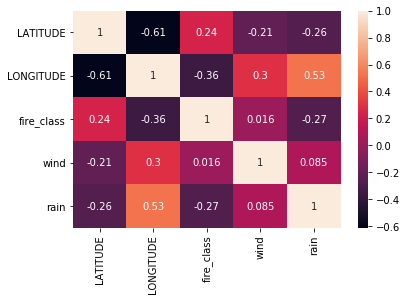

In [20]:
plt.figure()
sns.heatmap(corr,annot = True)
plt.show()

# correlate with near surface air pressure

In [22]:
PATH = "/run/media/leyan/8854FE2154FE11A4/ECE143dataset/adaptor.mars.internal.nc"
raw = iris.load_raw(PATH)
print(raw)
cube = raw[0] # cube0 is 10 metre wind speed
cube = cube.extract(iris.Constraint(expver = 1))

0: surface_air_pressure / (Pa)         (time: 493; expver: 2; latitude: 721; longitude: 1440)
1: 10 metre wind speed / (m s**-1)     (time: 493; expver: 2; latitude: 721; longitude: 1440)


In [23]:
cube

<iris 'Cube' of surface_air_pressure / (Pa) (time: 493; latitude: 721; longitude: 1440)>

In [3]:
%%time
air_pressure_series = []
for index, row in sample_df.iterrows():
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    air_pressure_series.append(query_wind(year, month, lat, long, cube))

In [28]:
sample_df['air_pressure'] = air_pressure_series
sample_df.to_csv('./sample_with_air_pressure.csv')

In [29]:
sample_df

,Unnamed: 0,LATITUDE,LONGITUDE,date,fire_class,wind,rain,air_pressure
0,17447,34.150278,-111.161111,2006-07-08 00:00:00,1,1.885379,1.62,83488.001293
1,1408617,34.549600,-83.314900,1997-09-05 00:00:00,1,2.074109,3.54,98583.801239
2,1774717,38.932217,-121.090600,2014-02-26 00:00:00,1,2.425365,4.55,95627.461316
3,661920,37.474330,-78.271670,2006-03-11 00:00:00,1,3.078590,0.76,100349.321228
4,69324,34.443333,-118.091667,1994-05-15 00:00:00,1,2.529557,0.14,88059.714344
...,...,...,...,...,...,...,...,...
3495,1564624,45.534167,-116.297500,2012-09-06 00:00:00,7,1.462686,0.12,86285.565225
3496,358740,35.507217,-83.457391,2001-11-10 00:00:00,7,2.028876,1.65,90951.335792
3497,628216,33.513660,-102.827900,2006-03-12 00:00:00,7,5.170843,0.34,88579.187967
3498,330099,43.146400,-113.563900,2007-08-16 00:00:00,7,4.055931,0.07,84636.538490


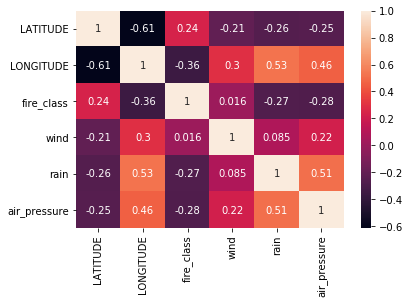

In [31]:
sample_df_show = sample_df.drop(columns=['date', 'Unnamed: 0'])
corr = sample_df_show.corr()
plt.figure()
sns.heatmap(corr,annot = True)
plt.show()